$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/danielbondar/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/danielbondar/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/danielbondar/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


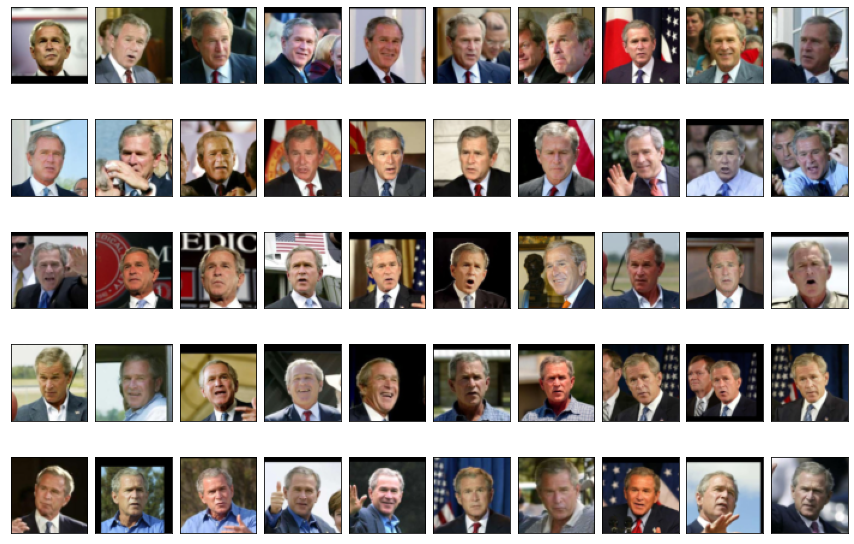

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.0, inplace=False)
    (8): Tanh()
    (9): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(6, 6))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
    (12): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.1)
    (15): Conv2d(256, 256, kernel_size=(5, 5), stride=(2, 2), paddi

**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): Upsample(scale_factor=2.0, mode=bicubic)
    (1): Conv2d(8, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Dropout2d(p=0.2, inplace=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Upsample(scale_factor=2.0, mode=bicubic)
    (9): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): Dropout2d(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.1)
    (13): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (14): Dropout2d(p=0.2, inplace=False)
    (15): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

/home/danielbondar/miniconda3/envs/cs236781-hw4/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [8]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [9]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

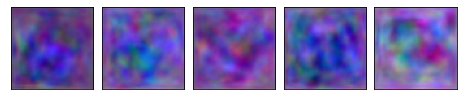

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 16, 'data_label': 1, 'label_noise': 0.08, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.001}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0005}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.89it/s]
Discriminator loss: 1.2515072733608645
Generator loss:     1.3231797538586516


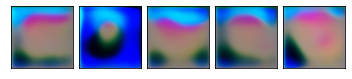

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]
Discriminator loss: 0.24866977812194113
Generator loss:     3.147444959896714


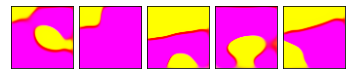

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.96it/s]
Discriminator loss: 0.011483237355836291
Generator loss:     4.588020854921483


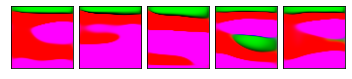

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]
Discriminator loss: 0.7105181586386552
Generator loss:     2.5919009144626446
Saved checkpoint.


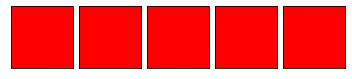

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]
Discriminator loss: 0.03023141794907513
Generator loss:     4.423895665069125


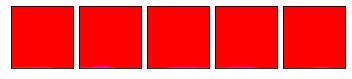

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.06it/s]
Discriminator loss: 0.012439271574144933
Generator loss:     5.451717793051876


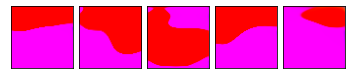

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.51it/s]
Discriminator loss: 0.41397017607493186
Generator loss:     4.023383017796189


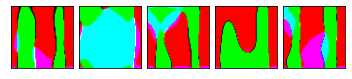

--- EPOCH 8/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.27it/s]
Discriminator loss: 0.1817524442032202
Generator loss:     3.617140549332348
Saved checkpoint.


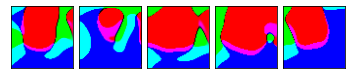

--- EPOCH 9/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.74it/s]
Discriminator loss: 0.0477006397724374
Generator loss:     5.414181018943217


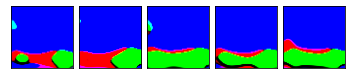

--- EPOCH 10/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]
Discriminator loss: 0.3451478480041694
Generator loss:     4.653565739517782


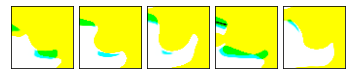

--- EPOCH 11/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.68it/s]
Discriminator loss: 1.1072684505592976
Generator loss:     5.146303216023232


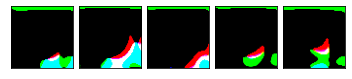

--- EPOCH 12/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]
Discriminator loss: 0.15648149910257825
Generator loss:     3.9730872787646394
Saved checkpoint.


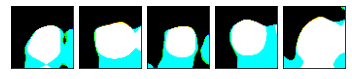

--- EPOCH 13/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.76it/s]
Discriminator loss: 0.05442525212889287
Generator loss:     4.338349708870275


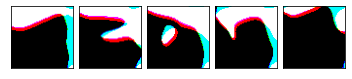

--- EPOCH 14/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.28it/s]
Discriminator loss: 0.12190753341749755
Generator loss:     4.759575690796126


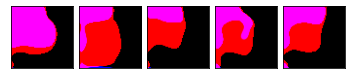

--- EPOCH 15/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.87it/s]
Discriminator loss: 0.03422038526788576
Generator loss:     5.834072895904086


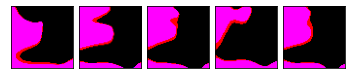

--- EPOCH 16/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.05it/s]
Discriminator loss: -0.06914299960011866
Generator loss:     5.193541170945808
Saved checkpoint.


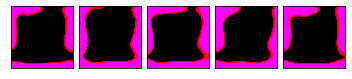

--- EPOCH 17/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.92it/s]
Discriminator loss: 0.015079493092289611
Generator loss:     5.157162837128141


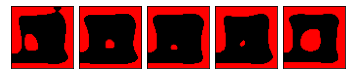

--- EPOCH 18/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.80it/s]
Discriminator loss: -0.011636882408786176
Generator loss:     5.706933363160091


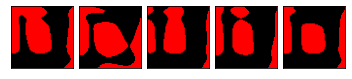

--- EPOCH 19/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]
Discriminator loss: 0.008567747729482935
Generator loss:     7.204473701875601


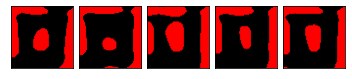

--- EPOCH 20/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.57it/s]
Discriminator loss: -0.01499332476462891
Generator loss:     7.234264708277005
Saved checkpoint.


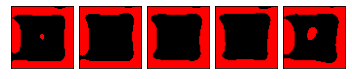

--- EPOCH 21/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.28it/s]
Discriminator loss: 0.005917151694867148
Generator loss:     7.399737955918953


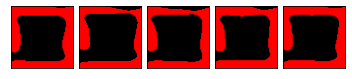

--- EPOCH 22/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.06it/s]
Discriminator loss: -0.015345327278126531
Generator loss:     7.435936564829812


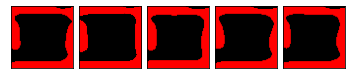

--- EPOCH 23/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.53it/s]
Discriminator loss: -0.05221445292734833
Generator loss:     7.029788266366987


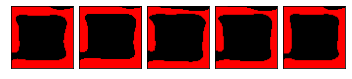

--- EPOCH 24/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.55it/s]
Discriminator loss: -0.03849583789150217
Generator loss:     6.325419618122614
Saved checkpoint.


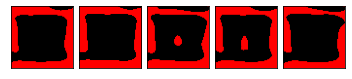

--- EPOCH 25/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.79it/s]
Discriminator loss: -0.07298775417591209
Generator loss:     7.087294564318301


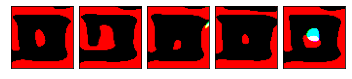

--- EPOCH 26/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]
Discriminator loss: 0.06398457127498157
Generator loss:     7.984521015366512


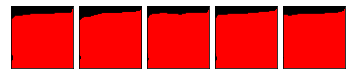

--- EPOCH 27/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.93it/s]
Discriminator loss: 0.01676858616853828
Generator loss:     8.339329883233825


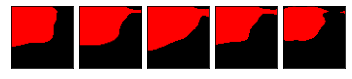

--- EPOCH 28/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.51it/s]
Discriminator loss: -0.10506178527625638
Generator loss:     6.974718257562438
Saved checkpoint.


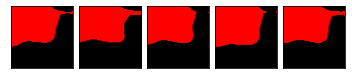

--- EPOCH 29/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.05it/s]
Discriminator loss: -0.05523731370470417
Generator loss:     9.487232535632689


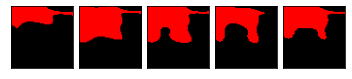

--- EPOCH 30/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.19it/s]
Discriminator loss: 0.1744631005645688
Generator loss:     7.14512462046609


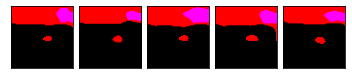

--- EPOCH 31/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.35it/s]
Discriminator loss: 0.005931792252544147
Generator loss:     7.3738251159440225


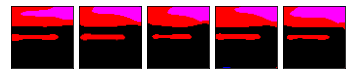

--- EPOCH 32/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.18it/s]
Discriminator loss: -0.02086895370661323
Generator loss:     8.30908937596563
Saved checkpoint.


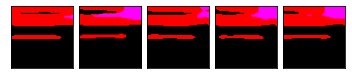

--- EPOCH 33/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.54it/s]
Discriminator loss: -0.00807680156248719
Generator loss:     7.591882655869669


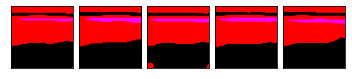

--- EPOCH 34/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]
Discriminator loss: 0.02425335647899713
Generator loss:     7.13003515841356


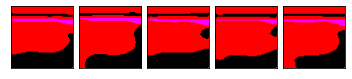

--- EPOCH 35/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]
Discriminator loss: -0.044699159186722626
Generator loss:     7.5695250496935484


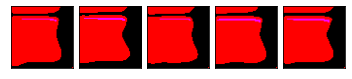

--- EPOCH 36/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]
Discriminator loss: -0.04439903195224591
Generator loss:     7.757102432535656
Saved checkpoint.


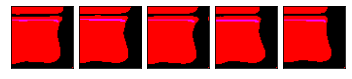

--- EPOCH 37/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.84it/s]
Discriminator loss: -0.01219187549023486
Generator loss:     9.244608822153575


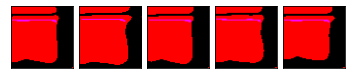

--- EPOCH 38/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.40it/s]
Discriminator loss: 0.08129502332477427
Generator loss:     7.400374327132951


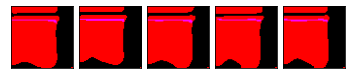

--- EPOCH 39/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]
Discriminator loss: -0.058745388108402935
Generator loss:     7.516824686705177


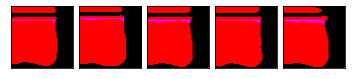

--- EPOCH 40/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]
Discriminator loss: 0.06993515594904103
Generator loss:     10.261853403119899
Saved checkpoint.


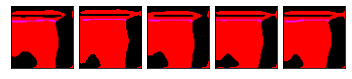

--- EPOCH 41/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.45it/s]
Discriminator loss: 0.008960284570704646
Generator loss:     10.012209194809643


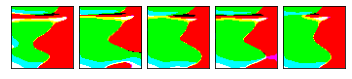

--- EPOCH 42/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.48it/s]
Discriminator loss: -0.030597002009180054
Generator loss:     7.984985084676031


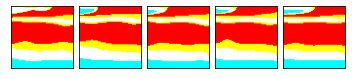

--- EPOCH 43/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.18it/s]
Discriminator loss: 0.07703752646139309
Generator loss:     6.554192172947214


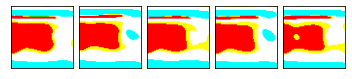

--- EPOCH 44/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]
Discriminator loss: -0.07094678988874849
Generator loss:     7.166554273064457
Saved checkpoint.


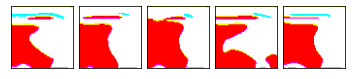

--- EPOCH 45/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.57it/s]
Discriminator loss: -0.03572561008049481
Generator loss:     9.599569676527336


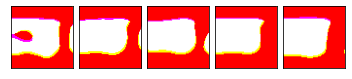

--- EPOCH 46/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.97it/s]
Discriminator loss: -0.041847936642258915
Generator loss:     10.333615851046433


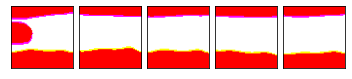

--- EPOCH 47/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.79it/s]
Discriminator loss: -0.1805702431210831
Generator loss:     7.81219580280247


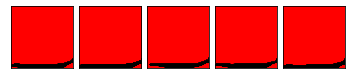

--- EPOCH 48/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]
Discriminator loss: 0.18245884642672183
Generator loss:     8.381524189194636
Saved checkpoint.


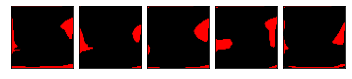

--- EPOCH 49/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.56it/s]
Discriminator loss: -0.07087252800589178
Generator loss:     7.303756051988744


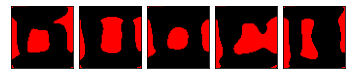

--- EPOCH 50/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.75it/s]
Discriminator loss: 0.1068685049218918
Generator loss:     7.116894423072018


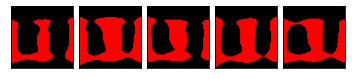

--- EPOCH 51/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.81it/s]
Discriminator loss: 0.06707437592211055
Generator loss:     7.97526712559942


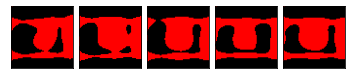

--- EPOCH 52/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]
Discriminator loss: -0.008385013872340544
Generator loss:     8.515124641247649
Saved checkpoint.


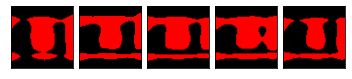

--- EPOCH 53/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]
Discriminator loss: -0.012663777806420825
Generator loss:     7.9295510605200015


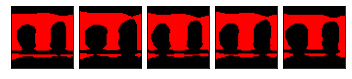

--- EPOCH 54/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.60it/s]
Discriminator loss: 0.08635967313798505
Generator loss:     9.40144880494075


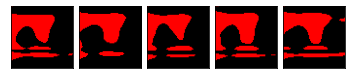

--- EPOCH 55/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.62it/s]
Discriminator loss: 0.09335895747279943
Generator loss:     7.165090404339691


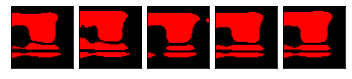

--- EPOCH 56/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]
Discriminator loss: 0.09001929490868725
Generator loss:     9.113641781593437
Saved checkpoint.


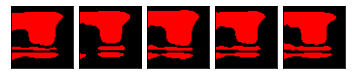

--- EPOCH 57/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.13it/s]
Discriminator loss: 0.08885971612449903
Generator loss:     10.335925682267145


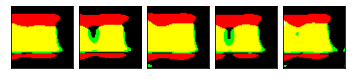

--- EPOCH 58/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]
Discriminator loss: 0.6134467839972296
Generator loss:     7.612484202456119


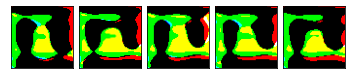

--- EPOCH 59/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.59it/s]
Discriminator loss: -0.09335182662775267
Generator loss:     6.046401696418648


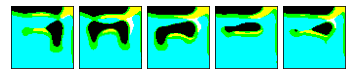

--- EPOCH 60/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.29it/s]
Discriminator loss: -0.043288924217001715
Generator loss:     7.291635068494882
Saved checkpoint.


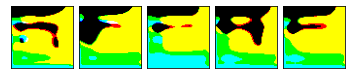

--- EPOCH 61/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.73it/s]
Discriminator loss: -0.140404276049404
Generator loss:     6.823346419120902


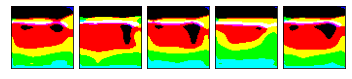

--- EPOCH 62/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.62it/s]
Discriminator loss: 0.2846146844216247
Generator loss:     11.479408427850524


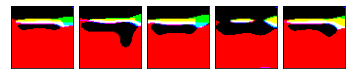

--- EPOCH 63/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.51it/s]
Discriminator loss: -0.06680831896947391
Generator loss:     6.197416426530525


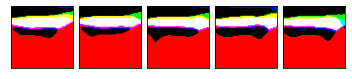

--- EPOCH 64/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.58it/s]
Discriminator loss: -0.037587635775110616
Generator loss:     6.201476481423449
Saved checkpoint.


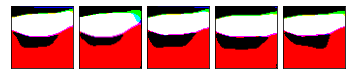

--- EPOCH 65/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.24it/s]
Discriminator loss: 0.16462754335866045
Generator loss:     7.5044322618797645


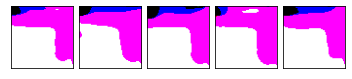

--- EPOCH 66/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.15it/s]
Discriminator loss: -0.1335249072246587
Generator loss:     8.636789300548497


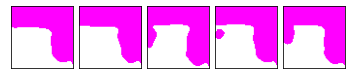

--- EPOCH 67/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.20it/s]
Discriminator loss: 0.10389390565566163
Generator loss:     9.956210079477794


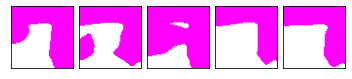

--- EPOCH 68/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.26it/s]
Discriminator loss: 0.09434579182138193
Generator loss:     8.49707757181196
Saved checkpoint.


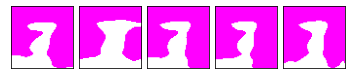

--- EPOCH 69/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]
Discriminator loss: 0.10333023317603034
Generator loss:     7.54518645557005


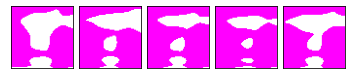

--- EPOCH 70/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]
Discriminator loss: 0.0708055569887606
Generator loss:     7.65880474403723


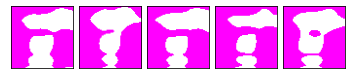

--- EPOCH 71/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.68it/s]
Discriminator loss: -0.04827651656719286
Generator loss:     5.908594159937617


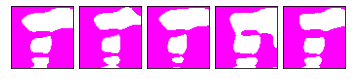

--- EPOCH 72/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.42it/s]
Discriminator loss: -0.056206530321445035
Generator loss:     6.153945346376789
Saved checkpoint.


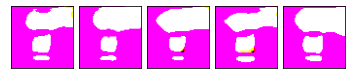

--- EPOCH 73/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.90it/s]
Discriminator loss: 0.17146884402565993
Generator loss:     7.170005670234339


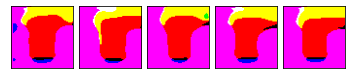

--- EPOCH 74/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.42it/s]
Discriminator loss: 0.06072019196268338
Generator loss:     8.483699314629854


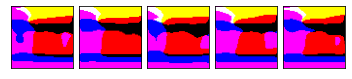

--- EPOCH 75/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.06it/s]
Discriminator loss: 0.008530071978248767
Generator loss:     6.34168376495589


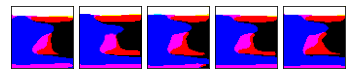

--- EPOCH 76/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]
Discriminator loss: -0.04234917220006238
Generator loss:     7.623490418960799
Saved checkpoint.


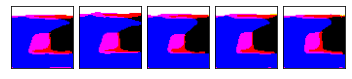

--- EPOCH 77/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.20it/s]
Discriminator loss: 0.053545348679841454
Generator loss:     7.806871179324477


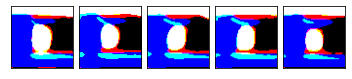

--- EPOCH 78/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.16it/s]
Discriminator loss: 0.007236303233388645
Generator loss:     10.167075356440758


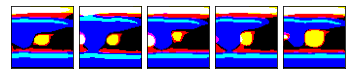

--- EPOCH 79/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.63it/s]
Discriminator loss: 0.15572922473856762
Generator loss:     7.534228858663075


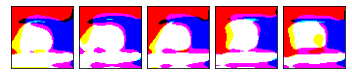

--- EPOCH 80/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.29it/s]
Discriminator loss: 0.06305907783446027
Generator loss:     7.1690062053167996
Saved checkpoint.


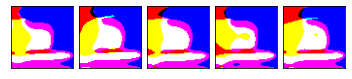

--- EPOCH 81/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.07it/s]
Discriminator loss: 0.059494388470454004
Generator loss:     7.220699530928882


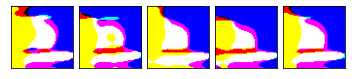

--- EPOCH 82/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.40it/s]
Discriminator loss: -0.025733554513374373
Generator loss:     7.279372265089804


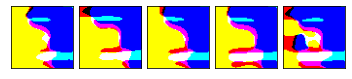

--- EPOCH 83/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.44it/s]
Discriminator loss: 0.07949466658617134
Generator loss:     6.6856690876519504


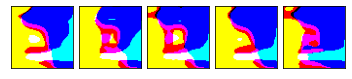

--- EPOCH 84/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.35it/s]
Discriminator loss: 0.010412833861895461
Generator loss:     6.275900406623954
Saved checkpoint.


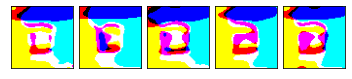

--- EPOCH 85/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.78it/s]
Discriminator loss: 0.017490307091554597
Generator loss:     6.913278287916041


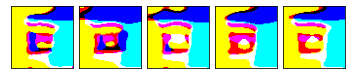

--- EPOCH 86/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]
Discriminator loss: 0.08553893427684237
Generator loss:     7.27273070634301


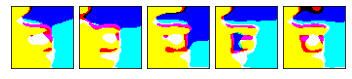

--- EPOCH 87/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.57it/s]
Discriminator loss: -0.07715794627568615
Generator loss:     5.964200788469457


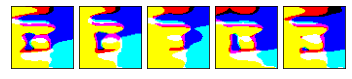

--- EPOCH 88/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]
Discriminator loss: 0.0753165814858764
Generator loss:     6.460347004790805
Saved checkpoint.


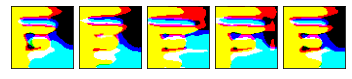

--- EPOCH 89/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.91it/s]
Discriminator loss: -0.07871461159257746
Generator loss:     7.424559208884168


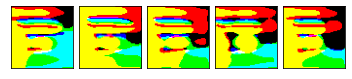

--- EPOCH 90/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.53it/s]
Discriminator loss: 0.005807645229706124
Generator loss:     6.127920905155922


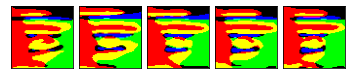

--- EPOCH 91/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.36it/s]
Discriminator loss: -0.03912799399512917
Generator loss:     7.497653114261912


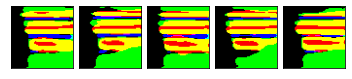

--- EPOCH 92/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.39it/s]
Discriminator loss: 0.09618625489633474
Generator loss:     14.517233193810306
Saved checkpoint.


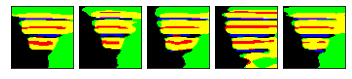

--- EPOCH 93/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.39it/s]
Discriminator loss: -0.023641079497426304
Generator loss:     11.179700787387677


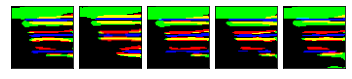

--- EPOCH 94/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.49it/s]
Discriminator loss: 0.04562512307024714
Generator loss:     7.221095451668127


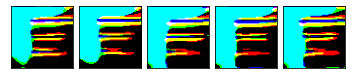

--- EPOCH 95/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.89it/s]
Discriminator loss: 0.14184554883126002
Generator loss:     4.761102018071644


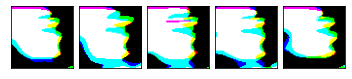

--- EPOCH 96/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.46it/s]
Discriminator loss: 0.33421744317261143
Generator loss:     8.011368578939296
Saved checkpoint.


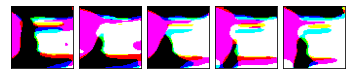

--- EPOCH 97/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.13it/s]
Discriminator loss: -0.024484212913397533
Generator loss:     6.07717922552308


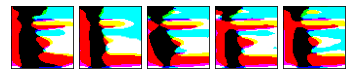

--- EPOCH 98/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 18.54it/s]
Discriminator loss: -0.12984834133244272
Generator loss:     8.081451259442229


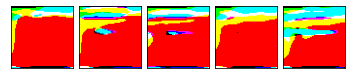

--- EPOCH 99/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.09it/s]
Discriminator loss: -0.036935481395739225
Generator loss:     8.870268351996122


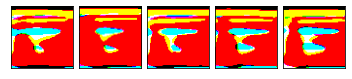

--- EPOCH 100/100 ---
 15%|████████████████▎                                                                                            | 10/67 [00:00<00:03, 18.96it/s]

In [ ]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

In [ ]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [ ]:
from cs236781.answers import display_answer
import hw4.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(answers.part3_q3)